### Question 2
Does a customer's overall discount rate effect their total purchase amount? 

### Importing Python Module 

In [1]:
from importlib import reload

import numpy as np
import pandas as pd

import sqlite3

# Removing red warnings
import warnings
warnings.filterwarnings('ignore')

# Power Analysis
from statsmodels.stats.power import tt_ind_solve_power,ttest_power

#For tukey test
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

#
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
figsize = (13,8)

import function as func

import scipy.stats as scs


ip


In [2]:
conn = func.MyConn(filename= 'Northwind_small.sqlite')

In [3]:
query =  """
            SELECT o.ID, CustomerID, ProductID, Quantity, Discount, UnitPrice
            FROM 'Order' as o
            JOIN 'OrderDetail' as od
            on o.ID = od.OrderID 
        """


In [4]:
df = conn.load_query_as_df(query)


In [5]:
df.CustomerId.describe()

count      2155
unique       89
top       SAVEA
freq        116
Name: CustomerId, dtype: object

In [6]:
# Adding the standard price
df['StandardPrice']= df.UnitPrice/(1- df.Discount)
# Line total
df['LineTotal'] = df.UnitPrice* df.Quantity
# Discounted Amount
df['StandardAmount'] = df.StandardPrice* df.Quantity
df.head()

,Id,CustomerId,ProductId,Quantity,Discount,UnitPrice,StandardPrice,LineTotal,StandardAmount
0,10248,VINET,11,12,0.0,14.0,14.0,168.0,168.0
1,10248,VINET,42,10,0.0,9.8,9.8,98.0,98.0
2,10248,VINET,72,5,0.0,34.8,34.8,174.0,174.0
3,10249,TOMSP,14,9,0.0,18.6,18.6,167.4,167.4
4,10249,TOMSP,51,40,0.0,42.4,42.4,1696.0,1696.0


In [7]:
columns = ['Quantity', 'LineTotal', 'StandardAmount', 'Discount']
df_customer = df.groupby('CustomerId')[columns].sum()
df_customer.Discount = (df_customer.StandardAmount- df_customer.LineTotal)/ df_customer.StandardAmount
df_customer = df_customer.rename(columns= {'LineTotal':'TotalSpent'})
df_customer.head()

,Quantity,TotalSpent,StandardAmount,Discount
CustomerId,,,,
ALFKI,174,4596.20,5013.647368,0.083262
ANATR,63,1402.95,1402.950000,0.000000
ANTO,359,7515.35,8079.340523,0.069807
AROUT,650,13806.50,14265.937822,0.032205
BERGS,1001,26968.15,29523.261111,0.086546


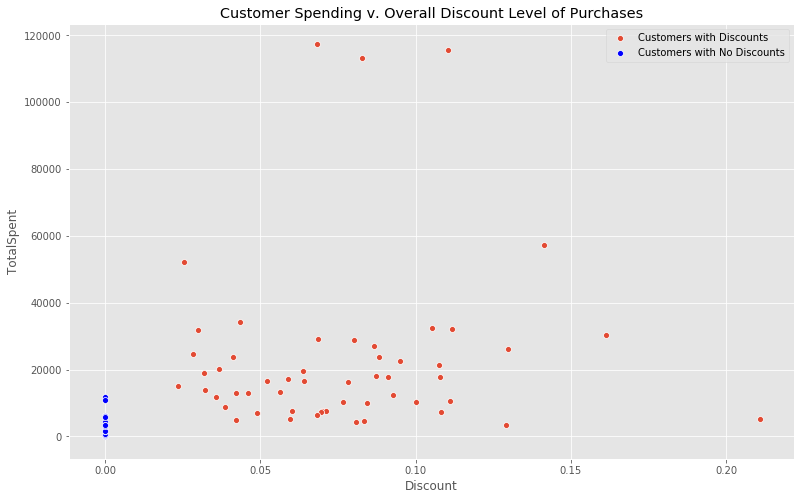

In [8]:
func.plotset(title= 'Customer Spending v. Overall Discount Level of Purchases')
sns.scatterplot(x= 'Discount', y= 'TotalSpent', data= df_customer, label='Customers with Discounts'); 
sns.scatterplot(x= 'Discount', y= 'TotalSpent', data= df_customer.loc[df_customer.Discount == 0], label='Customers with No Discounts',
                color= 'blue');
plt.legend()

There seems to be a distinct difference between discounted and non discounted, see blue markers on the plot. 

In [9]:
df_customer.loc[df_customer.Discount != 0].corr()

,Quantity,TotalSpent,StandardAmount,Discount
Quantity,1.000000,0.972739,0.973827,0.080549
TotalSpent,0.972739,1.000000,0.999041,0.083154
StandardAmount,0.973827,0.999041,1.000000,0.115591
Discount,0.080549,0.083154,0.115591,1.000000


There isn't much correlation between discount level and TotalSpent dollars among the discounted customers. 

Text(0.5, 1.0, 'Distribution of Total Dollars Spent by Customer of \n Undiscounted Customers V. Discounter Customers')

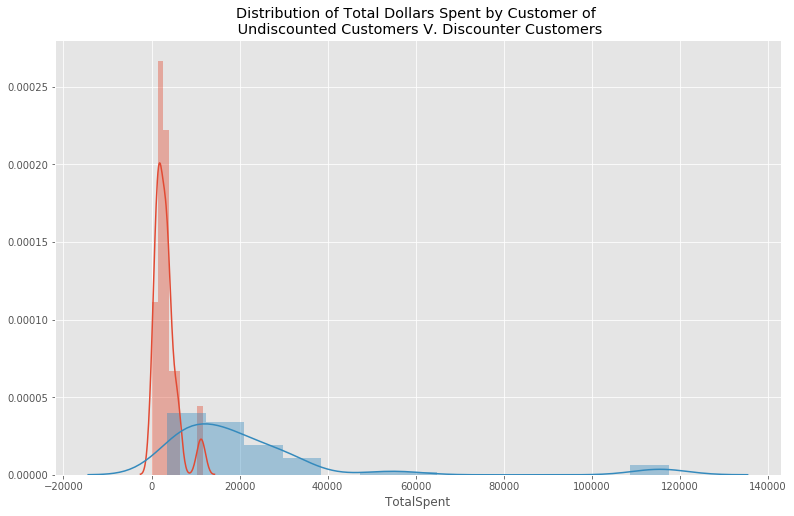

In [10]:
func.plotset()
sns.distplot(df_customer.loc[df_customer.Discount == 0].TotalSpent);
sns.distplot(df_customer.loc[df_customer.Discount != 0].TotalSpent);
plt.title('Distribution of Total Dollars Spent by Customer of \n Undiscounted Customers V. Discounter Customers')

In [11]:
func.df_binning(df_customer, column= 'Discount', bins=1)
df_customer.BinnedDiscount = df_customer.BinnedDiscount.astype(str)
df_customer.BinnedDiscount = df_customer.BinnedDiscount.replace(to_replace='nan', 
                                                                value='NoDiscount')

df_customer.head()

,Quantity,TotalSpent,StandardAmount,Discount,BinnedDiscount
CustomerId,,,,,
ALFKI,174,4596.20,5013.647368,0.083262,"(0.0, 0.211]"
ANATR,63,1402.95,1402.950000,0.000000,NoDiscount
ANTO,359,7515.35,8079.340523,0.069807,"(0.0, 0.211]"
AROUT,650,13806.50,14265.937822,0.032205,"(0.0, 0.211]"
BERGS,1001,26968.15,29523.261111,0.086546,"(0.0, 0.211]"


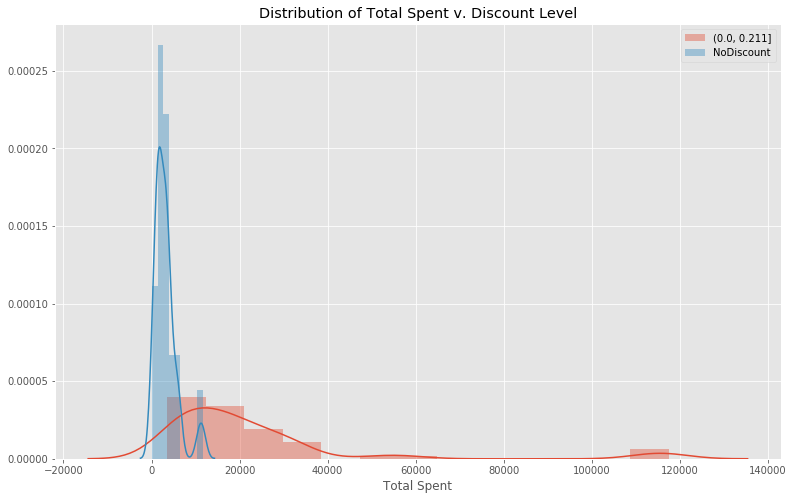

In [12]:
func.plotset(title='Distribution of Total Spent v. Discount Level')

for i in df_customer.BinnedDiscount.value_counts().index:
    
    sns.distplot(df_customer.loc[df_customer.BinnedDiscount== i].TotalSpent, label= i,axlabel='Total Spent')
    plt.legend()


In [13]:
df_discount = df_customer.groupby('BinnedDiscount')['TotalSpent', 'StandardAmount'].sum()
df_discount['CustomerCount'] = df_customer.groupby('BinnedDiscount')['Quantity'].count()
df_discount['AveragePerCustomer'] = df_discount.TotalSpent/ df_discount.CustomerCount
df_discount.head()

,TotalSpent,StandardAmount,CustomerCount,AveragePerCustomer
BinnedDiscount,,,,
"(0.0, 0.211]",1244123.19,1.353620e+06,54,23039.318333
NoDiscount,110335.40,1.103354e+05,35,3152.440000


#### Normalilty Shapiro Welk Test

In [14]:
for i in df_customer.BinnedDiscount.value_counts().index:
    print(i)
    print(func.shapiro_normal(df_customer.loc[df_customer.BinnedDiscount == i].TotalSpent))

(0.0, 0.211]
non normal
t 0.6238155364990234, p 1.635892254991944e-10
NoDiscount
non normal
t 0.8218997716903687, p 5.651193714584224e-05


#### Test analysis
The null hypothesis is that the tested distribution is normally distributed, and the alternative hypothesis is that the distribution is non-normal. A p values threshold is 0.05. 

The p values for the bootstrap order data are below 0.05, so they are non normal. Bootstrapping will need to be used.

In [15]:
df_mean_sampling = func.df_bootstrapping(df_customer, 'TotalSpent', bin_column='BinnedDiscount', num_of_samples= 35)

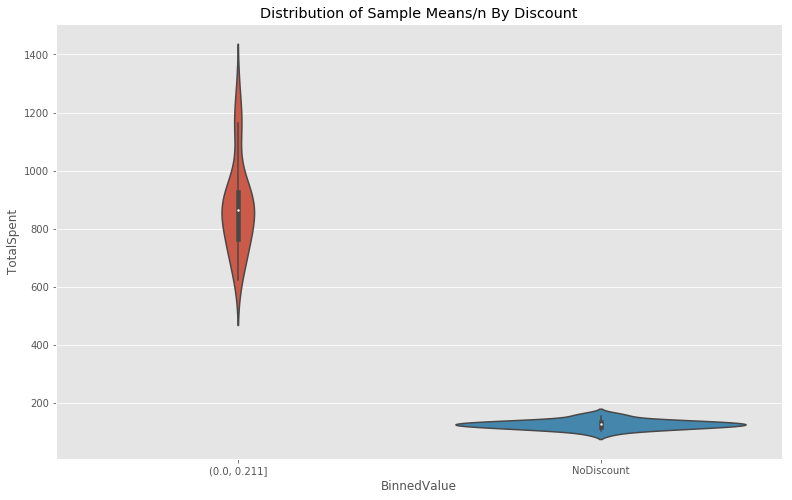

In [16]:
func.plotset(title='Distribution of Sample Means/n By Discount')
sns.violinplot(x= 'BinnedValue', y= 'TotalSpent', data= df_mean_sampling);

#### Normalilty Shapiro Welk Test

In [17]:
for i in df_mean_sampling.BinnedValue.value_counts().index:
    print(i)
    print(func.shapiro_normal(df_mean_sampling.loc[df_mean_sampling.BinnedValue == i].TotalSpent))

(0.0, 0.211]
non normal
t 0.9280422925949097, p 0.024476362392306328
NoDiscount
normal
t 0.9866995811462402, p 0.9400492906570435


#### Test analysis
The null hypothesis is that the tested distribution is normally distributed, and the alternative hypothesis is that the distribution is non-normal. A p values threshold is 0.05. 

*Null hypothesis was not rejected.* The p-values are above the threshold, so the distrbutions are normal. 


#### Variance Test

In [18]:
func.levene_variances(df_mean_sampling.loc[df_mean_sampling.BinnedValue == 'NoDiscount'].TotalSpent,
                      df_mean_sampling.loc[df_mean_sampling.BinnedValue == '(0.0, 0.211]'].TotalSpent)


p = 4.106068830965434e-07
Therefore the data do not have equal variances


False

#### Test analysis
The sample distributions don't have equal variances.

#### Effect Size

In [26]:
print(f"No Discount compared to Discounted")
print(-func.cohen_d(df_mean_sampling.loc[df_mean_sampling.BinnedValue == 'NoDiscount'].TotalSpent,
                      df_mean_sampling.loc[df_mean_sampling.BinnedValue == '(0.0, 0.211]'].TotalSpent))


No Discount compared to Discounted
6.736325547832778


#### Welch T-test 

In [19]:
scs.ttest_ind(df_mean_sampling.loc[df_mean_sampling.BinnedValue == 'NoDiscount'].TotalSpent,
                      df_mean_sampling.loc[df_mean_sampling.BinnedValue == '(0.0, 0.211]'].TotalSpent, equal_var=False)

Ttest_indResult(statistic=-28.180071557959714, pvalue=1.7148430384448146e-25)

#### Test analysis
*Rejected the null hypothesis*(the sample means are identical)

#### Effect Size

In [20]:
effect_size = func.cohen_d(df_mean_sampling.loc[df_mean_sampling.BinnedValue == '(0.0, 0.211]'].TotalSpent, 
             df_mean_sampling.loc[df_mean_sampling.BinnedValue == 'NoDiscount'].TotalSpent)
effect_size

6.736325547832778

In [21]:
tt_ind_solve_power(effect_size=effect_size, nobs1=35, alpha=0.5)

1.0

In [22]:
print(df_customer.loc[df_customer.Discount == 0].TotalSpent.mean()) 
print(df_customer.loc[df_customer.Discount != 0].TotalSpent.mean())
-df_customer.loc[df_customer.Discount == 0].TotalSpent.mean()+ df_customer.loc[df_customer.Discount != 0].TotalSpent.mean()

3152.44
23039.318333333336


19886.878333333338

### Conclusion 
There is statistical significant difference in total dollars spent with customers that received discount and those that did not. There is a $19,886.88 positive increase the average of the non discounted customer to the discounted customers Among the discounted customer, there did not seem to be a significant relationship between the spent and the level of discounts.

In [23]:
!jupyter nbconvert --to markdown Question2

[NbConvertApp] Converting notebook Question2.ipynb to markdown
[NbConvertApp] Support files will be in Question2_files\
[NbConvertApp] Making directory Question2_files
[NbConvertApp] Making directory Question2_files
[NbConvertApp] Making directory Question2_files
[NbConvertApp] Making directory Question2_files
[NbConvertApp] Writing 14492 bytes to Question2.md
